## 모델 동작에 필요한 사전 준비

In [1]:
! pip install tensorflow_datasets

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import Model, layers

## 데이터 불러오기 및 전처리

In [3]:
# 이번 GAN 실습에 활용될 MNIST 데이터를 다운로드한 후,
# 불러온 데이터를 Training용과 Testing용으로 나누는 과정
# 모든 이미지 데이터의 크기는 28 x 28 x 1 (흑백)

dataset = tfds.load('mnist', split = 'train')
batch_size = 1024
train_data = dataset.map(lambda data: tf.cast(data['image'], tf.float32) / 255.).batch(batch_size)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## GAN 구현

### GAN의 생성자 (Generator) 구현

In [5]:
""# GAN의 생성자 (Generator)

class Generator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        # 2D convolutional layer의 역연산에 해당하는 transposed 2D convolutional layer의 경우,
        # same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 두 배로 확장되는 효과!
        self.latent_dim = latent_dim
        self.generator = tf.keras.Sequential([
            layers.Dense(7 * 7 * 32, activation = 'relu'),                                          # (batch_size, 7 * 7 * 32) , input_shape = (latent_dim,)
            layers.Reshape((7, 7, 32)),                                                             # (batch_size, 7, 7, 32)
            layers.Conv2DTranspose(64, 3, strides = 2, padding = 'same', activation = 'relu'),      # (batch_size, 14, 14, 64)
            layers.Conv2DTranspose(32, 3, strides = 2, padding = 'same', activation = 'relu'),      # (batch_size, 28, 28, 32)
            layers.Conv2DTranspose(1, 3, strides = 1, padding = 'same', activation = 'sigmoid')     # (batch_size, 28, 28, 1)
        ])

    def call(self, z):
        return self.generator(z)

### GAN의 판별자 (Discriminator) 구현

In [6]:
# GAN의 판별자 (Discriminator)

class Discriminator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        # 2D convolutional layer에서 same padding을 적용하고 strides 값을 2로 할 경우 이미지의 크기가 절반으로 줄어드는 효과!
        self.latent_dim = latent_dim
        self.discriminator = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides = 2, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),    # (batch_size, 14, 14, 32)
            layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = 'same'),                               # (batch_size, 7, 7, 64)
            layers.Flatten(),                                                                                       # (batch_size, 7 * 7 * 64)
            layers.Dense(1)                                                                                         # (batch_size, )
        ])

    def call(self, x):
        return self.discriminator(x)

### GAN 구조 정의

In [7]:
# Hyperparameters

n_epochs = 200
latent_dim = 10
log_interval = 20

In [8]:
# GAN의 생성자와 판별자
generator = Generator(latent_dim)
discriminator = Discriminator(latent_dim)

# Optimizer 정의
optimizer_g = tf.keras.optimizers.Adam(1e-3)
optimizer_d = tf.keras.optimizers.Adam(1e-3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training

### Loss Function 정의

In [9]:
# Loss function은 binary cross entropy (BCE)로 정의

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [10]:
def train_step(inputs):
    noises = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:
        # noises: random noise 분포에서 sample된 벡터
        # x: noises로부터 생성된 MNIST 이미지
        # real_output: 실제 MNIST 이미지 판별 결과
        # fake_output: GAN의 생성자가 생성한 MNIST 이미지의 판별 결과

        x = generator(noises)

        real_output = discriminator(inputs)
        fake_output = discriminator(x)

        # Generator loss와 discriminator loss 계산
        loss_g = loss(tf.ones_like(fake_output), fake_output)
        loss_d = loss(tf.ones_like(real_output), real_output) + loss(tf.zeros_like(fake_output), fake_output)

    # GAN을 구성하는 생성자와 판별자의 gradient 값들을 계산하는 과정
    grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
    grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)

    # 계산된 gradient 값들을 기반으로 GAN의 생성자와 판별자를 optimize하는 과정
    optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return loss_g, loss_d

In [11]:
# 실제 Training 과정

for epoch in range(1, n_epochs + 1):
    total_loss_g, total_loss_d = 0, 0

    for x in train_data:
        loss_g, loss_d = train_step(x)
        total_loss_g += loss_g
        total_loss_d += loss_d

    if epoch % log_interval == 0:
        print(f'Epoch {epoch:3d} - Generator loss: {total_loss_g:.2f}, Discriminator loss: {total_loss_d:.2f}')

Epoch  20 - Generator loss: 127.74, Discriminator loss: 40.51
Epoch  40 - Generator loss: 94.50, Discriminator loss: 50.20
Epoch  60 - Generator loss: 78.36, Discriminator loss: 61.34
Epoch  80 - Generator loss: 70.96, Discriminator loss: 61.06
Epoch 100 - Generator loss: 81.81, Discriminator loss: 54.45
Epoch 120 - Generator loss: 79.12, Discriminator loss: 60.46
Epoch 140 - Generator loss: 67.37, Discriminator loss: 67.21
Epoch 160 - Generator loss: 61.75, Discriminator loss: 70.71
Epoch 180 - Generator loss: 62.27, Discriminator loss: 69.45
Epoch 200 - Generator loss: 61.74, Discriminator loss: 70.90


## Testing

### 생성자 동작 확인

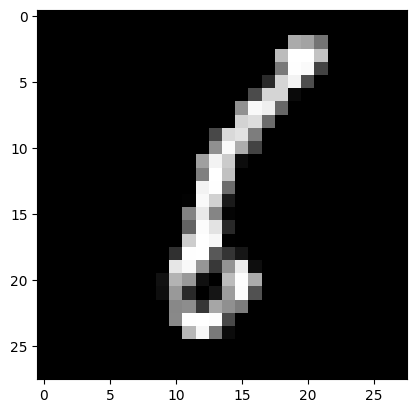

In [12]:
# 학습된 GAN 모델의 생성자로 MNIST 이미지 Sampling 및 시각화

noise = tf.random.normal([1, latent_dim])
x = generator(noise)
plt.imshow(x[0, :, :, 0], cmap = 'gray')

### 학습된 GAN 모델로 MNIST 이미지 생성

In [13]:
# 여러 개의 MNIST 이미지들을 Sampling하는 함수 정의
# n * n 정사각형 배치의 MNIST 이미지 생성 및 출력

def plot_latent_images(n, digit_size = 28):
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i in range(n):
        for j in range(n):
            noise = tf.random.normal([1, latent_dim])
            x = generator(noise)
            image[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = x[0, :, :, 0]

    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'Greys_r')
    plt.axis('Off')
    plt.show()

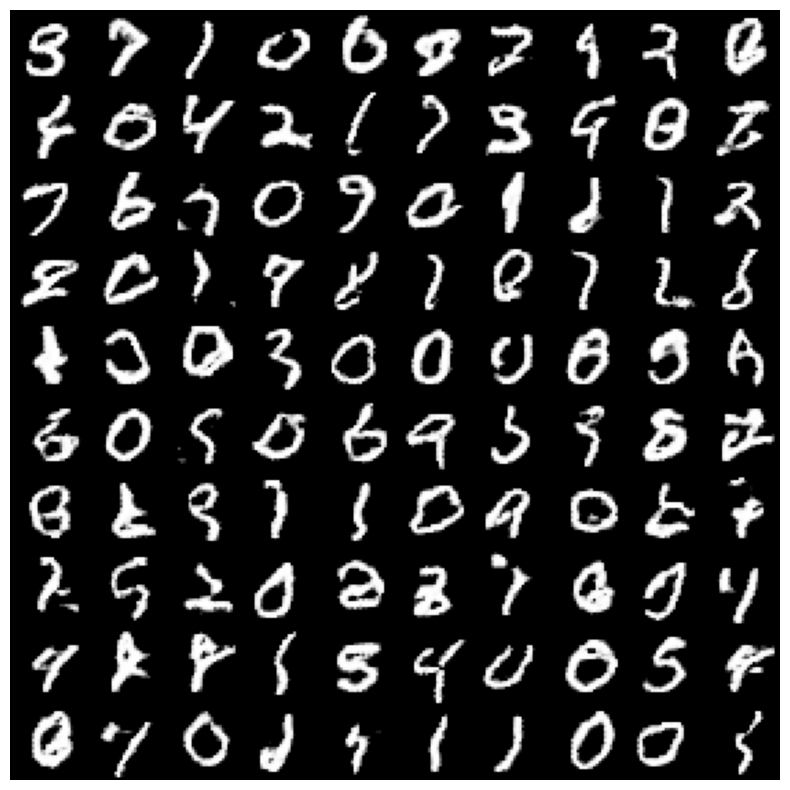

In [14]:
# MNIST 이미지 생성
# 여기서는 10 * 10 = 100개의 MNIST 이미지 생성

plot_latent_images(10)